In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as mpl
import scipy.stats as ss
from scipy.optimize import minimize
import random


mpl.rcParams.update({"font.size": 18})


In [5]:
x = np.arange(-99, 100)
np.array(np.meshgrid(*([x] * 4))).T.reshape(-1, 4)

KeyboardInterrupt: 

In [2]:
def net_sharpe(w1, mu, cov, w0, tc):
    return (w1.dot(mu) - cost_turnover(w0, w1, tc)) / np.sqrt(w1.dot(cov).dot(w1))


def obj_func(x, mu, cov):
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))
    # return 0.5 * (x.dot(cov).dot(x)) - x.dot(mu)


def find_optimal_wgt(mu, cov):
    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    cstr = [{"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}]
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=cstr,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    return np.sum(np.abs(w1 - w0) * tc) / 2


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    opt_net_sharpe = net_sharpe(opt_w, mu, cov, w0, tc)
    w1_net_sharpe = net_sharpe(w1, mu, cov, w0, tc)
    return opt_net_sharpe - w1_net_sharpe


# Bellman equation
# V(s) = max_a sum_s' P(s,a,s') * (r(s,a,s') + gamma * V(s'))
# where P(s,a,s') is the probability of transitioning from state s to state s' with action a, and gamma is a discount factor that determines the importance of future rewards.
# V(s) = max_a E_s'[ r(s,a,s') + gamma * V(s') ]
class BellmanValue:
    # it assumes fix mu and sigma_mat
    # to consider varying mu and sigma_mat, state space must be expanded, and expectation must consider future new mu and sigma_mat
    def __init__(self, mu, sigma_mat, transaction_cost, gamma):
        self.mu = mu
        self.sigma_mat = sigma_mat
        self.transaction_cost = transaction_cost
        self.gamma = gamma
        x = np.arange(-99, 100)
        self.action_possible = np.array(np.meshgrid(*([x] * len(self.mu)))).T.reshape(-1, len(self.mu))
        self.action_possible = self.action_possible[self.action_possible.sum(axis=1) == 0, :] / 100
        x = np.arange(1, 101)
        self.state_possible = np.array(np.meshgrid(*([x] * len(self.mu)))).T.reshape(-1, len(self.mu))
        self.state_possible = self.state_possible[self.state_possible.sum(axis=1) == 100, :] / 100
        self.value_table = np.zeros(self.state_possible.shape[0])
        self.q_table = np.zeros((self.state_possible.shape[0], self.action_possible.shape[0]))
        self.optimal_weight = find_optimal_wgt(mu, sigma_mat)

    def get_transition_prob(self, state_wgt):
        ret_drift = self.state_possible / state_wgt
        ret_drift -= 1
        # this is only an approximation, it hasn't considered the weight renormalization
        probabilities = ss.multivariate_normal.pdf(ret_drift, mean=self.mu, cov=self.sigma_mat)
        probabilities /= np.sum(probabilities)
        # probabilities = np.zeros(len(self.state_possible))
        # idx = np.argmin(np.abs(self.state_possible[:, 0] - state_wgt[0]))
        # probabilities[idx] = 1
        return probabilities

    def calculate_value(self, state_wgt):
        action_value_current_state = []
        for action_id in range(self.action_possible.shape[0]):
            action = self.action_possible[action_id]
            new_state = state_wgt + action
            if np.any(new_state <= 0):
                action_value = -np.inf
            else:
                transition_prob = self.get_transition_prob(new_state)
                reward = -expected_cost_total(state_wgt, new_state, self.optimal_weight, self.mu, self.sigma_mat,
                                              self.transaction_cost)
                next_state_value = self.value_table
                action_value = np.sum(transition_prob * (reward + self.gamma * next_state_value))
            action_value_current_state.append(action_value)
        return action_value_current_state

    def iterate_q_table_once(self):
        new_value_table = np.zeros(self.state_possible.shape[0])
        new_q_table = np.zeros((self.state_possible.shape[0], self.action_possible.shape[0]))
        for state_id in range(self.state_possible.shape[0]):
            state_wgt = self.state_possible[state_id]
            new_q_table[state_id, :] = self.calculate_value(state_wgt)
            new_value_table[state_id] = np.max(new_q_table[state_id, :])

        check_converged = np.sum(np.abs(self.value_table - new_value_table))
        self.value_table = new_value_table
        self.q_table = new_q_table

        return check_converged

    def iterate(self):
        print("Iteration Start")
        for dummy in range(500):
            diff = self.iterate_q_table_once()
            if diff < 1e-5:
                print(f"Iteration finish at step {dummy}")
                break
            print("\t iter {}: Value {}".format(dummy, diff))

In [3]:
n_manager = 2
mu = np.array([50, 200]) / 1e4
sigma = np.array([300, 800]) / 1e4
cov = np.diag(sigma ** 2)
optimal_weight = find_optimal_wgt(mu, cov)
x0 = np.ones(len(mu)) / len(mu)

In [4]:
# model_result = {}
# for tc in [0, 0.0005, 0.001, 0.002]:
#     self = bell = BellmanValue(mu, cov, tc, gamma=0.9)
#     bell.iterate()
#     model_result[tc] = bell

# x = self.state_possible[:, 0]
# action_df = pd.DataFrame(index=x)
# action_bm_df = pd.DataFrame(index=x)
# for tc, bell in model_result.items():
#     # visualize q table
#     action = np.array([bell.action_possible[i, 0] for i in bell.q_table.argmax(axis=1)])
#     action_df[f"TC: {tc * 1e4:.0f} bps"] = action
#     action_bm = []
#     for i in x:
#         a = x[np.argmax([net_sharpe(np.array([j, 1 - j]), mu, cov, np.array([i, 1 - i]), tc) for j in x])] - i
#         action_bm.append(a)
#     action_bm = np.array(action_bm)
#     action_bm_df[f"TC: {tc * 1e4:.0f} bps BM"] = action_bm
#
# fig, ax = mpl.subplots(1, 1, figsize=(20, 10))
# action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
# ax.set_xlabel("Weight on First Asset")
# ax.set_ylabel("Suggested Delta Weight on Asset 1")
# ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
# ax.axhline(0, color="red", linestyle="dotted")
# ax.legend()
# mpl.tight_layout()
# mpl.show()
# mpl.savefig(os.path.expanduser(f"~/Desktop/q_table.png"))
# mpl.close()
#
# bell_action_df = action_df.copy()

In [5]:
# Q-values
# Q(s, a) = Q(s, a) + alpha * (r + gamma * max_a' Q(s', a') - Q(s, a))
# where alpha is the learning rate (a small positive value that determines the weight given to new observations), r is the reward received for taking action a in state s,
# gamma is the discount factor (a value between 0 and 1 that determines the importance of future rewards), s' is the next state, and a' is the optimal action to take in state s' (according to the current Q-values).
# We can use an epsilon-greedy policy to select actions during the learning process. With probability epsilon, the agent selects a random action (exploration), and with probability 1 - epsilon, the agent selects the action with the highest Q-value (exploitation).
class Qlearning(BellmanValue):
    # same assumption for constant mu and sigma_mat
    def __init__(self, mu, sigma_mat, transaction_cost, gamma, epsilon=0.1, learning_rate=0.1):
        super().__init__(mu, sigma_mat, transaction_cost, gamma)
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.num_actions = self.action_possible.shape[0]
        self.num_states = self.state_possible.shape[0]
        for state_id in range(self.num_states):
            state = self.state_possible[state_id]
            self.q_table[state_id, np.argwhere(np.any(state + self.action_possible <= 0, axis=1))] = -np.inf

    def get_next_state(self, state, action):
        new_state = state + action
        # remove stochastic component to be consistent with the value iteration because value iteration hasn't considered the weight renormalization
        random_ret = np.random.multivariate_normal(self.mu, self.sigma_mat, size=1)
        new_state = new_state * (1+random_ret)
        new_state = new_state / np.sum(new_state)
        new_state = np.round(new_state, 2)
        return new_state

    def q_learning_once(self, state_id):
        state_wgt = self.state_possible[state_id, :]

        if random.uniform(0, 1) < self.epsilon:
            action_feasible = np.argwhere(self.q_table[state_id, :] > -np.inf).reshape([-1])
            action_id = np.random.choice(action_feasible, 1).item()
        else:
            action_id = np.argmax(self.q_table[state_id, :])
        action = self.action_possible[action_id, :]

        # Get the next state and reward
        next_state = self.get_next_state(state_wgt, action)
        next_state_id = np.argwhere(np.all(self.state_possible == next_state, axis=1)).item()
        reward = -expected_cost_total(state_wgt, state_wgt+action, self.optimal_weight, self.mu, self.sigma_mat,
                                      self.transaction_cost)
        update_amount = reward + self.gamma * np.max(self.q_table[next_state_id, :]) - self.q_table[state_id, action_id]
        self.q_table[state_id, action_id] += self.learning_rate * update_amount

        return next_state_id

    def set_value_fun_from_q_table(self):
        for state_id in range(self.state_possible.shape[0]):
            self.value_table[state_id] = np.max(self.q_table[state_id, :])

    def iterate(self, num_episodes = 1000, max_steps_per_episode = 100):
        print("Iteration Start")
        for i in range(num_episodes):
            print("Epoch {}".format(i))
            current_state = random.randint(0, self.num_states - 1)
            for j in range(max_steps_per_episode):
                current_state = self.q_learning_once(current_state)

In [6]:
# qmodel_result = {}
# for tc in [0, 0.0005, 0.001, 0.002]:
#     qlearner = Qlearning(mu, cov, tc, gamma=0.9, epsilon=0.1, learning_rate=0.1)
#     qlearner.iterate(num_episodes = 10000, max_steps_per_episode = 1000)
#     qmodel_result[tc] = qlearner
#
# # while True:
# #     for tc in [0.0005, 0.001, 0.002]:
# #         qlearner = qmodel_result[tc]
# #         qlearner.iterate(num_episodes = 10000, max_steps_per_episode = 1000)
#
# x = self.state_possible[:, 0]
# ql_action_df = pd.DataFrame(index=x)
# for tc, mo in qmodel_result.items():
#     # visualize q table
#     action = np.array([mo.action_possible[i, 0] for i in mo.q_table.argmax(axis=1)])
#     ql_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

# fig, ax = mpl.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
# ax.set_xlabel("Weight on First Asset")
# ax.set_ylabel("Suggested Delta Weight on Asset 1")
# ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
# ax.axhline(0, color="red", linestyle="dotted")
# ax.legend()
# mpl.tight_layout()
# mpl.show()
# mpl.savefig(os.path.expanduser(f"~/Desktop/bell_qlearn.png"))
# mpl.close()

In [50]:
# DQN is a variant of Q-learning that uses a neural network to estimate the Q-values instead of a table.
# The neural network takes the state as input and outputs a Q-value for each action.
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import torch
import torch.nn as nn
import torch.optim as optim

# Define the Q network
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNlearning(Qlearning):
    def __init__(self, mu, sigma_mat, transaction_cost, gamma, min_epsilon=0.1, learning_rate=0.001):
        super().__init__(mu, sigma_mat, transaction_cost, gamma, min_epsilon, learning_rate)

        # Initialize the Q network and optimizer
        self.input_size = len(mu)
        self.output_size = self.num_actions
        self.q_network = QNetwork(self.input_size, self.output_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Define the epsilon and learning rate
        self.epsilon = 1.0
        self.min_epsilon = min_epsilon
        self.epsilon_decay = 0.9999
        self.learning_rate = learning_rate

        # Define the replay buffer and batch size
        self.replay_buffer = []
        self.max_replay_buffer_size = 100000
        self.batch_size = 100

        # add loss
        self.loss = torch.tensor(0.)
        self.rewards = 0
        self.rewards_sum = 0


    def network_training_once(self, state_id):
        state_wgt = self.state_possible[state_id, :]

        # Choose the action using an epsilon-greedy policy
        self.epsilon *= self.epsilon_decay
        self.epsilon = np.maximum(self.epsilon, self.min_epsilon)
        if random.uniform(0, 1) < self.epsilon:
            action_feasible = np.argwhere(self.q_table[state_id, :] > -np.inf).reshape([-1])
            action_id = np.random.choice(action_feasible, 1).item()
        else:
            q_values = self.q_network(torch.FloatTensor(state_wgt))  # q_table lookup now changes to NN approximation
            action_id = torch.argmax(q_values).item()

        action_delta = self.action_possible[action_id]

        # Get the distribution of next states and rewards for the current state and action
        # reward_dist = rewards[next_state_dist]

        # Get the next state from the distribution
        next_state = self.get_next_state(state_wgt, action_delta)

        if np.any(next_state <= 0):
            next_state_id = state_id
            print("HERE")
            reward = -1
        else:
            next_state_id = np.argwhere(np.all(self.state_possible == next_state, axis=1)).item()
            reward = -expected_cost_total(state_wgt, state_wgt + action_delta, self.optimal_weight,
                                          self.mu, self.sigma_mat, self.transaction_cost)
            # print(reward)

        # Add the experience to the replay buffer
        self.replay_buffer.append((state_id, action_id, next_state_id, reward))

        # If the replay buffer is full, remove the oldest experience
        if len(self.replay_buffer) > self.max_replay_buffer_size:
            self.replay_buffer.pop(0)

        # Sample a batch of experiences from the replay buffer
        if len(self.replay_buffer) >= self.batch_size:
            batch = random.sample(self.replay_buffer, self.batch_size)

            # Calculate the Q-value targets for the batch using the Q network
            states = np.zeros((self.batch_size, self.input_size))
            q_targets = np.zeros((self.batch_size, self.output_size))
            reward_k_list = []
            for k in range(self.batch_size):
                # TODO: Can possibly not loop through batch_size but instead sample an entire batch immediately
                # like in CartPole

                # get batch sample
                state_id_k, action_id_k, next_state_id_k, reward_k = batch[k]
                # get possible states at batch k
                state_wgt_k = self.state_possible[state_id_k]
                # compute target Q values
                q_values_k = self.q_network(torch.FloatTensor(state_wgt_k))  # next Q-Value
                q_targets_this_state_all_action = q_values_k.clone().detach().numpy()
                q_targets_this_state_all_action[action_id_k] = reward_k + self.gamma * np.max(q_targets_this_state_all_action)
                q_targets[k] = q_targets_this_state_all_action  # target Q-Value
                states[k] = state_wgt_k
                reward_k_list.append(reward_k)

            # store rewards for each batch
            self.rewards = np.mean(reward_k_list)
            self.rewards_sum = np.sum(reward_k_list)

            # Update the Q network using the batch
            self.loss = torch.tensor(0.)
            for k in range(self.batch_size):
                q_values = self.q_network(torch.FloatTensor(states[k]))
                self.loss += nn.SmoothL1Loss()(q_values, torch.FloatTensor(q_targets[k]))
            self.optimizer.zero_grad()
            self.loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.q_network.parameters(), 100)
            self.optimizer.step()



        # In this code, we sample a batch of experiences from the replay buffer using the random.sample function,
        # and then calculate the Q-value targets for the batch using the Q network.
        # We then update the Q network using the batch by calculating the loss and calling loss.backward() and optimizer.step().
        # Finally, we update the epsilon value using the decay factor.
        return next_state_id

    def iterate(self, num_episodes=1000, max_steps_per_episode=100):
        for i in range(num_episodes):
            print(f"Epoch {i}: Loss = {self.loss.item()} | Avg Batch Reward = {self.rewards} | Sum Batch Reward {self.rewards_sum} | epsilon = {self.epsilon}")
            current_state = random.randint(0, self.num_states - 1)
            for j in range(max_steps_per_episode):
                current_state = self.network_training_once(current_state)



In [ ]:
dqn_result = {}
dqn_loss = {}
for tc in [0, 0.0005, 0.001, 0.002]:
    dqn = DQNlearning(mu, cov, tc, gamma=0.9, min_epsilon=0.1, learning_rate=0.001)
    dqn.iterate(num_episodes=1000, max_steps_per_episode=100)
    dqn_result[tc] = dqn

# while True:
#     for tc in [0, 0.0005, 0.001, 0.002]:
#         dqn = qmodel_result[tc]
#         dqn.iterate(num_episodes = 10000, max_steps_per_episode = 1000)

x = dqn.state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc, mo in dqn_result.items():
    # visualize q table
    action = []
    for j in range(mo.state_possible.shape[0]):
        qval = mo.q_network(torch.FloatTensor(mo.state_possible[j])).detach().numpy()
        action.append(mo.action_possible[qval.argmax(), 0])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

dqn_action_df

Epoch 0: Loss = 0.0 | Avg Batch Reward = 0 | Sum Batch Reward 0 | epsilon = 1.0
Epoch 1: Loss = 0.013139482587575912 | Avg Batch Reward = -0.030065083296394183 | Sum Batch Reward -3.006508329639418 | epsilon = 0.9900493386913721
Epoch 2: Loss = 0.012580716982483864 | Avg Batch Reward = -0.03099705559973165 | Sum Batch Reward -3.099705559973165 | epsilon = 0.980197693043223
Epoch 3: Loss = 0.02506326697766781 | Avg Batch Reward = -0.030168230354779536 | Sum Batch Reward -3.0168230354779535 | epsilon = 0.970444077784251
HERE
HERE
Epoch 4: Loss = 0.006679398473352194 | Avg Batch Reward = -0.03825552685966592 | Sum Batch Reward -3.825552685966592 | epsilon = 0.9607875174472562
HERE
HERE
HERE
HERE
Epoch 5: Loss = 0.003195706056430936 | Avg Batch Reward = -0.040325710858615624 | Sum Batch Reward -4.032571085861562 | epsilon = 0.9512270462715811
HERE
Epoch 6: Loss = 0.000710248714312911 | Avg Batch Reward = -0.03435817892750133 | Sum Batch Reward -3.4358178927501326 | epsilon = 0.941761708106

,TC: 0 bps,TC: 5 bps,TC: 10 bps,TC: 20 bps
0.01,0.93,0.90,0.89,0.89
0.02,0.68,0.90,0.89,0.59
0.03,0.68,0.90,0.39,0.58
0.04,0.68,0.03,0.39,0.58
0.05,0.68,0.03,0.39,0.54
...,...,...,...,...
0.95,-0.34,-0.72,-0.77,-0.25
0.96,-0.34,-0.72,-0.77,-0.25
0.97,-0.88,-0.72,-0.88,-0.25
0.98,-0.88,-0.72,-0.88,-0.25


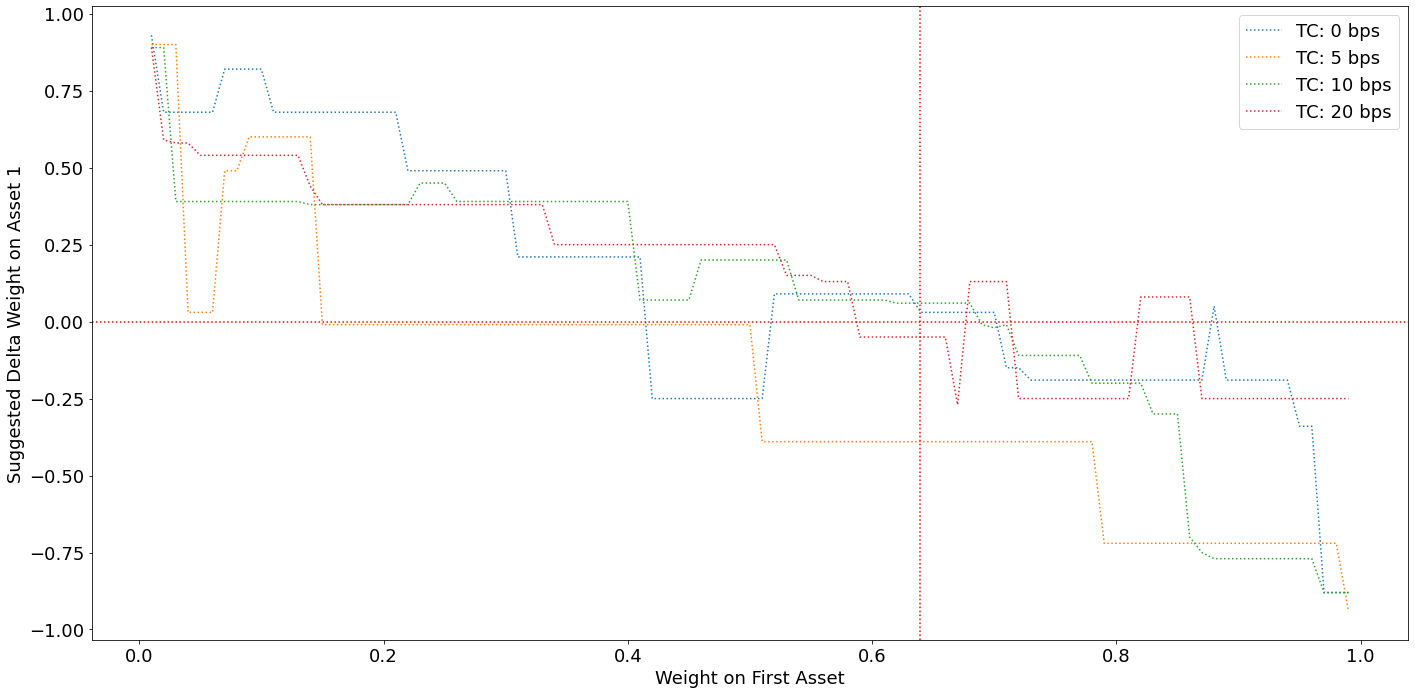

In [52]:
fig, ax = mpl.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
mpl.tight_layout()
mpl.show()
# mpl.savefig(os.path.expanduser(f"~/Desktop/bell_qlearn_dqn.png"))
# mpl.close()


In [56]:
mpl.savefig("bell_qlearn_dqn")

<Figure size 432x288 with 0 Axes>

In [3]:
mu = np.array([50, 200]) / 1e4
sigma = np.array([300, 800]) / 1e4
cov = np.diag(sigma ** 2)
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2019, 12, 31)
dates = pd.date_range(start, end, freq="M")
ret = np.random.multivariate_normal(mu / 12, cov / 12, size=len(dates))
ret_df = pd.DataFrame(ret, index=dates)
trans_cost = 10/1e4

num_episodes = 1000
max_steps_per_episode = 100

In [ ]:

dqn_result = {}
for tc in [0, 0.0005, 0.001, 0.002]:
    dqn = DQNlearning(mu, cov, tc, gamma=0.9, epsilon=0.1, learning_rate=0.001)
    dqn.iterate(num_episodes=100, max_steps_per_episode=100)
    dqn_result[tc] = dqn

# while True:
#     for tc in [0, 0.0005, 0.001, 0.002]:
#         dqn = qmodel_result[tc]
#         dqn.iterate(num_episodes = 10000, max_steps_per_episode = 1000)

x = dqn.state_possible[:, 0]
dqn_action_df = pd.DataFrame(index=x)
for tc, mo in dqn_result.items():
    # visualize q table
    action = []
    for j in range(mo.state_possible.shape[0]):
        qval = mo.q_network(torch.FloatTensor(mo.state_possible[j])).detach().numpy()
        action.append(mo.action_possible[qval.argmax(), 0])

    action = np.array(action)
    dqn_action_df[f"TC: {tc * 1e4:.0f} bps"] = action

print(dqn_action_df)

fig, ax = mpl.subplots(1, 1, figsize=(20, 10))
# ql_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
# bell_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
dqn_action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dotted")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
mpl.tight_layout()
mpl.show()
mpl.savefig(os.path.expanduser(f"~/Desktop/bell_qlearn_dqn.png"))
mpl.close()
